In [1]:
import os, sys
import numpy as np
import h5netcdf

import xarray as xr
import xarray.ufuncs as xu
import pandas as pd
import xrft

from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy

plt.rc("figure", figsize=(18,8))
plt.rc("font", size=14)
ccrs.PlateCarree()

from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4)
client = Client(cluster)
client



/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37837 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:37837/status,
Dashboard: http://137.129.155.67:37837/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: inproc://137.129.155.67/14035/1,Workers: 1
Dashboard: http://137.129.155.67:37837/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: inproc://137.129.155.67/14035/3,Total threads: 4
Dashboard: http://137.129.155.67:43685/status,Memory: 78.61 GiB
Nanny: None,


In [2]:
indir_anom = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/OLR/'
filenames = np.arange(2001,2013)
datasets = []
for f in filenames:
    ds = xr.open_mfdataset(indir_anom + '*'+str(f)+'*.nc', chunks={'time': None,'latitude' : 1})
    datasets.append(ds)
ds = xr.concat(datasets, dim='time', coords='minimal', compat='override')
ds['time'] = pd.date_range(start="2001", end="2012-12-31 22:00:00", freq='3H')
ds

<xarray.Dataset>
Dimensions:  (time: 35064, lon: 360, lat: 60)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 ... 2012-12-31T21:00:00
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
Data variables:
    OLR_ano  (time, lat, lon) float64 dask.array<chunksize=(2920, 60, 360), meta=np.ndarray>

In [3]:
ds = ds.chunk({'time' : None, 'lat' : 1})
with ProgressBar():
    tcwvhat = xrft.power_spectrum(ds['OLR_ano'],
                             dim=['time','lon'], true_phase=False, true_amplitude=True)
tcwvhat

<xarray.DataArray 'rechunk-merge-9f4afc130142760d59808b1e5cc11fd7' (freq_time: 35064, lat: 60, freq_lon: 360)>
dask.array<mul, shape=(35064, 60, 360), dtype=float64, chunksize=(35064, 1, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 -29.5 -28.5 -27.5 -26.5 ... 26.5 27.5 28.5 29.5
  * freq_time  (freq_time) float64 -4.63e-05 -4.629e-05 ... 4.629e-05 4.629e-05
  * freq_lon   (freq_lon) float64 -0.5 -0.4972 -0.4944 ... 0.4917 0.4944 0.4972

In [18]:
indir_anom = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/TCWV/'
indir_TF = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/TF2D/TCWV/'

# ds_mean_anom = xr.open_dataset(indir_anom + 'MEAN/mean_anomaly_tcwv_ERA5_3H_1990_2020.nc', chunks = {'time' : None,'latitude':1})
# ds_mean_anom

filenames = np.arange(2014,2016)
# datasets = []
# for f in filenames:
#     ds = xr.open_dataset(indir_TF + 'TF2D_ERA5_3H_tcwv_'+str(f)+'.nc', chunks={'freq_time': 1}, engine = "h5netcdf")
#     datasets.append(ds)
# ds = xr.concat(datasets, dim='time', coords='minimal', compat='override')
ds = xr.open_dataset(indir_TF + 'TF2D_ERA5_3H_tcwv_'+str(2014)+'.nc', chunks={'freq_time': 1}, engine = "h5netcdf")
ds1 = xr.open_dataset(indir_TF + 'TF2D_ERA5_3H_tcwv_'+str(2015)+'.nc', chunks={'freq_time': 1}, engine = "h5netcdf")


In [19]:
ds.freq_time.values

array([-4.62962963e-05, -4.62803321e-05, -4.62643678e-05, ...,
        4.62484036e-05,  4.62643678e-05,  4.62803321e-05])

In [20]:
ds1.freq_time.values

array([-4.62962963e-05, -4.62803321e-05, -4.62643678e-05, ...,
        4.62484036e-05,  4.62643678e-05,  4.62803321e-05])

In [21]:
import xarray.ufuncs as xu


tcwvhat = (xu.conj(ds)*ds).real

In [3]:
with ProgressBar():
    tcwvhat = xrft.power_spectrum(ds_mean_anom['tcwv_ano'],
                             dim=['time','longitude'], true_phase=False, true_amplitude=True)
#     vhat2 = xrft.power_spectrum(grid.interp(v,'Y',boundary='fill')[:,0].chunk({'time':1}),
#                              dim=['XC','YC'], detrend='linear', window=True).compute()

NameError: name 'ds_mean_anom' is not defined

In [12]:
tcwvhat = tcwvhat.where(tcwvhat.freq_time < 1/(3600*100), drop = True)
tcwvhat = tcwvhat.where(tcwvhat.freq_longitude < 0.33, drop = True)
tcwvhat = tcwvhat.where(tcwvhat.freq_longitude > -0.33, drop = True)
# tcwvhat_s = tcwvhat.sel(latitude = 0).load()
tcwvhat 

/home/durandy/miniconda3/envs/towel/lib/python3.8/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/durandy/miniconda3/envs/towel/lib/python3.8/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key

,Array,Chunk
Bytes,98.76 TiB,3.29 GiB
Shape,"(29016, 6149, 321, 237)","(5808, 1, 321, 237)"
Count,718852 Tasks,30745 Chunks
Type,float64,numpy.ndarray


In [5]:
radius = 6371e3
radian = tcwvhat['lat']*np.pi/180
radian
# _varhat = varhat.sel(latitude = l)
deg_to_m = 111110


wav_number = (2*np.pi*radius*np.cos(radian))/40075e3
minVal = (2*np.pi*radius*np.cos(radian))/20
minVal
# 1/tcwvhat.freq_longitude.values*111111
test = 1/(tcwvhat.freq_lon.values)*deg_to_m
valDeg = 1/minVal*deg_to_m
# np.min(valDeg)


/tmp/ipykernel_14035/742743228.py:12: RuntimeWarning: divide by zero encountered in true_divide
  test = 1/(tcwvhat.freq_lon.values)*deg_to_m


In [6]:
_tcwvhat = tcwvhat.where(tcwvhat.freq_time > 0, drop = True)
_tcwvhat = _tcwvhat.where(tcwvhat.freq_lon < valDeg, drop = True)
_tcwvhat = _tcwvhat.where(tcwvhat.freq_lon > -valDeg, drop = True)
_tcwvhat['freq_time'] = _tcwvhat['freq_time']*86400
_tcwvhat = _tcwvhat.where(_tcwvhat.freq_time < 0.6, drop = True)

# _tcwvhat = _tcwvhat.where(tcwvhat.freq_time < 1/(3600*100), drop = True)

# xr.where(tcwvhat.freq_longitude > 0.33,  0., tcwvhat )
waveN = (2*np.pi*radius)/(1/_tcwvhat.freq_lon.values*deg_to_m) 
_tcwvhat = _tcwvhat.assign_coords(wavenumber = ("freq_lon", waveN))
_tcwvhat

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key

<xarray.DataArray 'rechunk-merge-9f4afc130142760d59808b1e5cc11fd7' (freq_time: 2629, lat: 60, freq_lon: 45)>
dask.array<where, shape=(2629, 60, 45), dtype=float64, chunksize=(2629, 1, 45), chunktype=numpy.ndarray>
Coordinates:
  * freq_lon    (freq_lon) float64 -0.06111 -0.05833 ... 0.05833 0.06111
  * lat         (lat) float32 -29.5 -28.5 -27.5 -26.5 ... 26.5 27.5 28.5 29.5
  * freq_time   (freq_time) float64 0.0002282 0.0004563 ... 0.5996 0.5998
    wavenumber  (freq_lon) float64 -22.02 -21.02 -20.02 ... 20.02 21.02 22.02

In [7]:
_tcwvhat = _tcwvhat.sel(lat = slice(-15, 15))#mean('latitude')
_tcwvhat = _tcwvhat.sum('lat')
_tcwvhat = xu.log10(_tcwvhat) 
_tcwvhat = _tcwvhat.load()

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


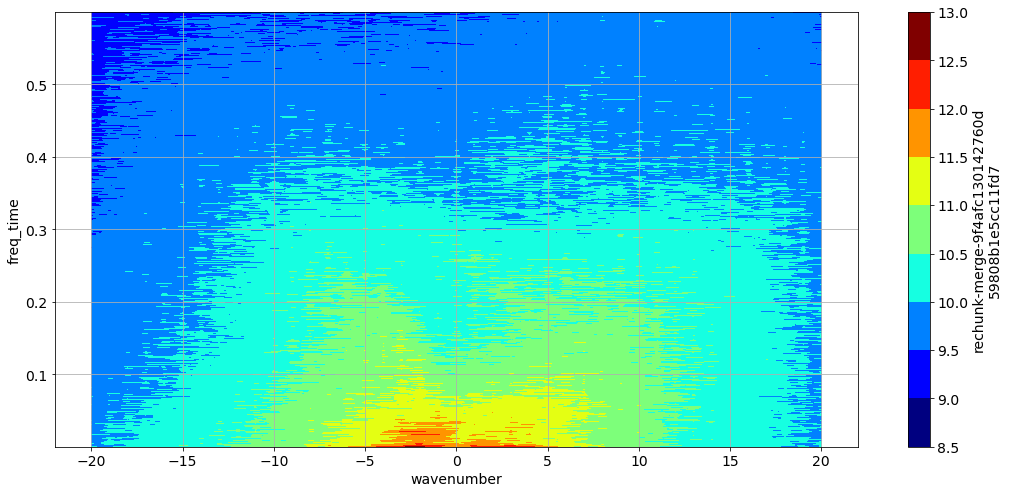

In [10]:


_tcwvhat.plot.contourf(x= "wavenumber", y = "freq_time", levels = 10, cmap= 'jet')
# plt.xaxes(_tcwvhat.wavenumber)
plt.grid()

In [13]:
_tcwvhat

<xarray.DataArray 'rechunk-merge-408236681b84794315c58d7bc79cddc7' (freq_time: 2629, freq_lon: 45)>
array([[           nan, 1.73224587e+08, 2.10292717e+08, ...,
        2.75774271e+08, 4.06009347e+08,            nan],
       [           nan, 3.22936634e+08, 1.57288922e+08, ...,
        1.52012160e+08, 2.75630958e+08,            nan],
       [           nan, 1.05118507e+08, 1.29336081e+08, ...,
        1.16056391e+08, 1.85413058e+08,            nan],
       ...,
       [           nan, 2.89720170e+07, 5.31160496e+07, ...,
        5.80911201e+07, 5.39395422e+06,            nan],
       [           nan, 1.11558798e+08, 1.04009868e+08, ...,
        3.86331829e+07, 1.62676534e+07,            nan],
       [           nan, 1.59968181e+08, 3.56488833e+07, ...,
        7.56726352e+07, 2.32261789e+07,            nan]])
Coordinates:
  * freq_lon    (freq_lon) float64 -0.06111 -0.05833 ... 0.05833 0.06111
  * freq_time   (freq_time) float64 0.0002282 0.0004563 ... 0.5996 0.5998
    wavenumber  (freq_lon) float64 -22.02 -21.02 -20.02 ... 20.02 21.02 22.02

In [85]:
_tcwvhat
__tcwvhat = _tcwvhat.where(_tcwvhat.freq_time < 0.6, drop = True)
1/__tcwvhat.freq_time

<xarray.DataArray 'freq_time' (freq_time: 2629)>
array([4.38300000e+03, 2.19150000e+03, 1.46100000e+03, ...,
       1.66844309e+00, 1.66780822e+00, 1.66717383e+00])
Coordinates:
  * freq_time  (freq_time) float64 0.0002282 0.0004563 ... 0.5996 0.5998

In [83]:
4383/365

12.008219178082191